In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from itertools import cycle
from sklearn import ensemble
import time

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from scipy import interp
import statsmodels.api as sm
from sklearn.metrics import recall_score

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [26]:
df_cardio = pd.read_csv('Cardiotocography.csv', sep=',')

df_cardio.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [33]:
df_cardio.columns

Index(['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')

In [27]:
null_data = df_cardio[df_cardio.isnull().any(axis=1)]
null_data

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,0.481,0.015,0.015,0.001,0.005,87.0,7.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_cardio = df_cardio.dropna()

In [32]:
df_cardio[df_cardio.columns[0:]].corr()['NSP'][:]#.sort_index()

LB          0.148151
AC         -0.364066
FM          0.088010
UC         -0.204894
DL          0.058870
DS          0.131934
DP          0.484859
ASTV        0.471191
MSTV       -0.103382
ALTV        0.426146
MLTV       -0.226797
Width      -0.068789
Min         0.063175
Max        -0.045265
Nmax       -0.023666
Nzeros     -0.016682
Mode       -0.250412
Mean       -0.226985
Median     -0.205033
Variance    0.206630
Tendency   -0.131976
NSP         1.000000
Name: NSP, dtype: float64

In [6]:
df_cardio = df_cardio.drop(['Min','Mean','Mode'], axis=1)

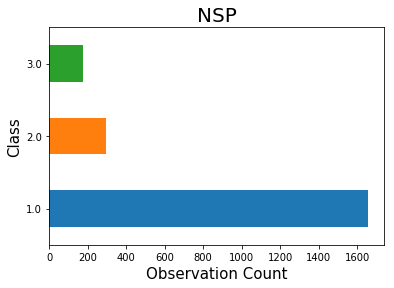

In [7]:
df_cardio['NSP'].value_counts()[:].plot(kind='barh')
plt.title('NSP',fontsize=20)
plt.xlabel('Observation Count',fontsize=15)
plt.ylabel('Class',fontsize=15)
plt.savefig('target__distribution.png')

## Train-Validation Split

In [98]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 

## Train-Test Split

In [99]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 


## Baseline LR Model

In [80]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

logreg = LogisticRegression()
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print('Cross_val score: {}\n'.format(cross_val_score(logreg, X_test, y_test, cv=20).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_logreg, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of logistic regression classifier on test set: 0.873

Cross_val score: 0.8670312143996355

Recall score: 0.8732394366197183

--- 0.3623538017272949 seconds ---


In [82]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9267895151313882


## Feature Selection

### SelectKBest: f_classif

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif

In [14]:
def get_selectKbest_scores(feature_amount):
    score = []
    y = df_cardio['NSP']
    X = df_cardio.drop('NSP',axis=1)
    
    for i in range(1,feature_amount+1):
        
        selector = SelectKBest(f_classif, k = i)

        selector.fit(X, y)

        X_new = selector.transform(X)

        y_new = df_cardio['NSP']

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 465) 
                   
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, 
                                                                            random_state = 465) 
                   
        logreg = LogisticRegression()
        logreg.fit(X_train_sub, y_train_sub)
        
        score.append(cross_val_score(logreg, X_test, y_test, cv=20).mean())
        
    #return score
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(1,feature_amount+1), score, color='blue', linestyle='dashed', marker='o',  
    markerfacecolor='blue', markersize=10)    
    plt.title('Score vs Best Feature Count')  
    plt.xlabel('Feature Count')  
    plt.ylabel('Score')

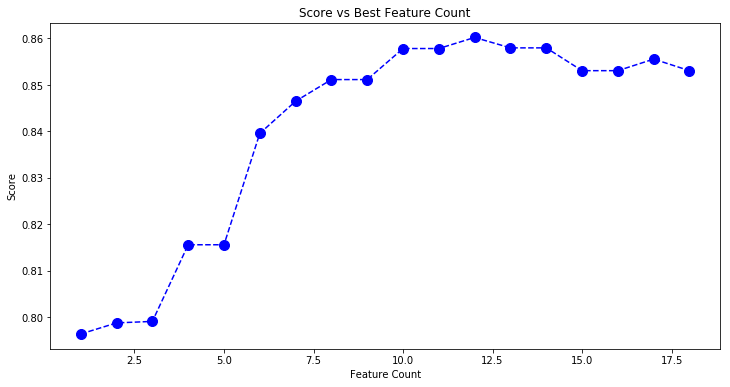

In [15]:
get_selectKbest_scores(18)

In [100]:
selector = SelectKBest(f_classif, k=12)

selector.fit(X, y)

X_new = selector.transform(X)

X_new.shape
print("feature indices: {}\n".format(selector.get_support(indices=True)))

y = df_cardio['NSP']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
                   
logreg = LogisticRegression()
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg, pos_label=2)
print('AUC score: {:.4f}\n'.format(auc(fpr, tpr)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())


feature indices: [ 0  1  3  6  7  8  9 12 16 17 18 19]

Accuracy of logistic regression classifier on test set: 0.878

AUC score: 0.6700

0.8697710184552289


In [88]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))


Average AUC score: 0.9267895151313882


### L1 Based Feature Elimination

In [20]:
from sklearn.feature_selection import SelectFromModel

y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [21]:
logreg = LogisticRegression(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)

print("feature indices: {}\n".format(model.get_support(indices=True)))

feature indices: [ 0  7  9 10 11 12 15 16]



In [101]:
y = df_cardio['NSP']
X = df_cardio[['LB','ASTV','ALTV','MLTV','Width','Max','Median','Variance']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

logreg = LogisticRegression()
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())


Accuracy of logistic regression classifier on test set: 0.857

0.8557017543859649


In [90]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9243386504553769


### L2 Based Feature Elimination

In [23]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [24]:
logreg = LogisticRegression(C=0.01, penalty="l2", dual=False).fit(X, y)
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)

print("feature indices: {}\n".format(model.get_support(indices=True)))

feature indices: [ 0  7  8 13 15 17]



In [102]:
y = df_cardio['NSP']
X = df_cardio[['LB','ASTV','ALTV','MSTV','Nmax','Median','Tendency']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

logreg = LogisticRegression()
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())


Accuracy of logistic regression classifier on test set: 0.854

0.8390009113693324


In [92]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9208851988750494


### Recursive Feature Elimination

In [104]:
from sklearn.feature_selection import RFE

y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [105]:
logreg = LogisticRegression()

rfe = RFE(logreg, 4)

fit = rfe.fit(X, y)

X_new = rfe.transform(X)

X_new.shape
print("feature indices: {}\n".format(selector.get_support(indices=True)))

y = df_cardio['NSP']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
                   
logreg = LogisticRegression()
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())


feature indices: [ 0  1  3  6  7  8  9 12 16 17 18 19]

Accuracy of logistic regression classifier on test set: 0.796

0.7964342674868992


In [57]:
def get_RFE_scores(feature_amount):
    score = []
    y = df_cardio['NSP']
    X = df_cardio.drop('NSP',axis=1)
    
    for i in range(1,feature_amount+1):
        logreg = LogisticRegression()

        rfe = RFE(logreg, i)

        fit = rfe.fit(X, y)
        
        X_new = rfe.transform(X)

        #print("feature indices: {}\n".format(selector.get_support(indices=True)))

        y = df_cardio['NSP']

        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 465) 
                   
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
                   
        logreg = LogisticRegression()
        
        logreg.fit(X_train_sub, y_train_sub)
        
        score.append(cross_val_score(logreg, X_test, y_test, cv=20).mean())
    
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(1,feature_amount+1), score, color='blue', linestyle='dashed', marker='o',  
    markerfacecolor='blue', markersize=10)    
    plt.title('Score vs Best Feature Count')  
    plt.xlabel('Feature Count')  
    plt.ylabel('Score')

        

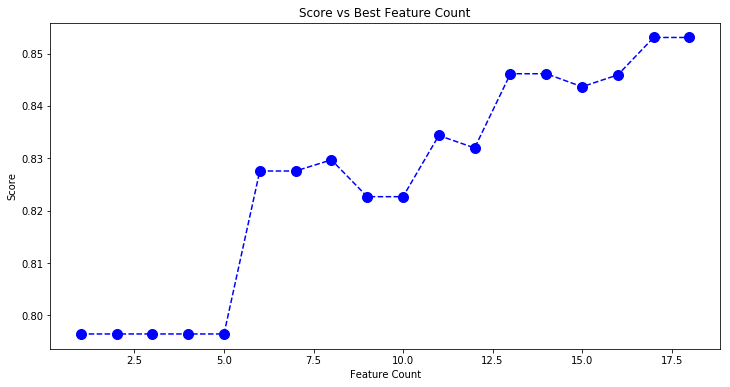

In [58]:
get_RFE_scores(18)

## Change LR Solver

In [81]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 


In [69]:
logreg = LogisticRegression(solver='newton-cg')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.885

0.8722601959444065


In [71]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.843

0.8438710412394623


In [73]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.866

0.8530701754385965


In [77]:
logreg = LogisticRegression(solver='sag')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.843

0.8579744816586921


In [79]:
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.843

0.8534290271132375


## Change LR balance

In [84]:
logreg = LogisticRegression(solver='newton-cg',class_weight='balanced')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.833

0.8622351332877649


## Change LR regularization

In [86]:
logreg = LogisticRegression(solver='newton-cg',penalty = 'l2')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.885

0.8722601959444065


In [95]:
logreg = LogisticRegression(solver='saga',penalty = 'elasticnet',l1_ratio = .5)
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.843

0.8558099794941899


In [96]:
logreg = LogisticRegression(solver='liblinear',penalty = 'l1')
logreg.fit(X_train_sub, y_train_sub)

y_pred_logreg = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}\n'.format(logreg.score(X_test, y_test)))

print(cross_val_score(logreg, X_test, y_test, cv=20).mean())

Accuracy of logistic regression classifier on test set: 0.864

0.8554511278195489


## Final LR model

In [97]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

start_time = time.time()

logreg = LogisticRegression(solver='newton-cg')
logreg.fit(X_train_sub, y_train_sub)

predict_train_logreg = logreg.predict(X_train)
predict_test_logreg = logreg.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_logreg, margins=True)
table_test = pd.crosstab(y_test, predict_test_logreg, margins=True)
print('Accuracy of logistic regression classifier on test set: {:.4f}\n'.format(logreg.score(X_test, y_test)))

print('Cross validation score: {:.4f}\n'.format(cross_val_score(logreg, X_test_sub, y_test_sub, cv=20).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_logreg, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of logistic regression classifier on test set: 0.8779

Cross validation score: 0.8892

Recall score: 0.8544600938967136

--- 7.64731502532959 seconds ---


In [103]:
print(np.unique(y_pred_svc))

[1. 2. 3.]


In [104]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       339
         2.0       0.55      0.50      0.52        48
         3.0       0.78      0.54      0.64        39

    accuracy                           0.87       426
   macro avg       0.75      0.67      0.70       426
weighted avg       0.86      0.87      0.86       426



- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
- The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
- The support is the number of occurrences of each class in y_test.

In [105]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_logreg, margins=True)
table_test = pd.crosstab(y_test, predict_test_logreg, margins=True)

train_tI_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc['All',1.0]))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc['All',2.0]))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc['All',3.0])))/3 

train_tII_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc[1.0,'All']))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc[2.0,'All']))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc[3.0,'All'])))/3 

test_tI_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc['All',1.0]))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc['All',2.0]))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc['All',3.0])))/3 

test_tII_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc[1.0,'All']))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc[2.0,'All']))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc[3.0,'All'])))/3 
print((
    'Training set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
AVG Percent Type I errors: 0.18180985515791226
AVG Percent Type II errors: 0.2666165141071346

Test set accuracy:
AVG Percent Type I errors: 0.19818673189649086
AVG Percent Type II errors: 0.28521859163452085


In [106]:
print((
    'Accuracy Differentials:\n'
    'Type I error difference: {}\n\n'
    'Type II error difference: {}\n'
).format(test_tI_errors - train_tI_errors, test_tII_errors - train_tII_errors))

Accuracy Differentials:
Type I error difference: 0.0163768767385786

Type II error difference: 0.01860207752738624



## ROC Curve

In [52]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

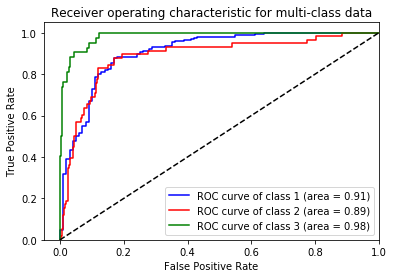

In [62]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

classifier = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
y_score = classifier.fit(X, y).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig('ROC_LogReg.png')
plt.show()